## Подключитесь к базе. Загрузите таблицы sql

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import random
from pandas.core.common import flatten
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint as sp_randint



from sklearn. model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix



from catboost import CatBoostClassifier, Pool, metrics
from catboost import CatBoostClassifier
from catboost import cv


import warnings

In [ ]:
warnings.filterwarnings('ignore')

## Шаг 1. Загрузка таблиц SQL

Подключаемся к базе

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

Загрузим таблицы sql. Для этого напишем функцию, на вход которой будет подаваться имя таблицы, которой нужно считать из sql. На выходе этой функции будет датафрейм.
В функции будет выполняться запрос из sql   `SELECT * FROM 'название таблицы'`

In [ ]:
def read_data_sql(table):
    query = '''
    SELECT *
    FROM '''+ table
    df = pd.read_sql_query(query, con = engine)
    return df

Считаем данные из sql таблиц в датафреймы с аналогичными названиями с помощью вышенаписанной функции. Будем выполнять считываение каждой таблицы в отдельной ячейке, так как при попытке считать все сразу ядро 'умирает'.

In [ ]:
collisions = read_data_sql('collisions')
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [ ]:
del(collisions)

In [ ]:
parties = read_data_sql('parties')
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [ ]:
del(parties)

In [ ]:
case_ids = read_data_sql('case_ids')
case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [ ]:
del(case_ids)

In [ ]:
vehicles = read_data_sql('vehicles')
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [ ]:
del(vehicles)

**ВЫВОД**


**Все таблицы считаны в датафреймы, через sql-запросы**

## Шаг 2. Проведем первичное исследование таблиц

Согласно предоставленому заданию на проект имеется полный набор таблиц: `case_ids`, `vehicles`, `parties`, `collisions`.

Все таблицы имеют общий ключ `case_id`.

Далее проанализируем все таблицы на предмет пропущенных значений.

Напишем функцию на вход, которой будет подаваться sql -запрос. На выходе результат этого запроса.

In [ ]:
def run_sql(query):
    query = query
    df = pd.read_sql_query(query, con = engine)
    return df


Выведем строки из таблицы `case_ids`, где есть хотя бы одно пропущенное значение.

In [ ]:
run_sql('''
SELECT *
FROM case_ids
WHERE case_id IS NULL OR db_year IS NULL
''')

,case_id,db_year


**Пропущенных значений в таблице `case_ids `нет.**

Проанализируем столбец `vehicles`.

In [ ]:
df = run_sql('''
SELECT *
FROM vehicles v
WHERE id IS NULL OR case_id IS NULL OR party_number IS NULL
OR vehicle_type IS NULL OR vehicle_transmission IS NULL
OR vehicle_age IS NULL
        ''')
df


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175960,5305242,2,sedan,None,4.0
1,1175915,5305196,1,sedan,manual,NaN
2,1175938,5305226,2,sedan,manual,NaN
3,1227485,5357864,1,sedan,manual,NaN
4,1227486,5357864,2,sedan,manual,NaN
...,...,...,...,...,...,...
42535,1175043,5304333,2,sedan,manual,NaN
42536,1175097,5304381,2,sedan,manual,NaN
42537,1175110,5304392,2,sedan,manual,NaN
42538,1175316,5304648,2,sedan,None,9.0


Далее спомощью pandas определим,количество пропущенных значений в каждом столбце.

In [ ]:
df.isna().sum()

id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

In [ ]:
del(df)

**В таблице `vehicles`, имеются пропущенные значения:**

 **- 23659 в столбце `vehicle_transmission`**

 **- 24582 в столбце `vehicle_age`**

При попытке аналогичным способом проанализировать остальные таблицы, ядро также 'умирает'. Поэтом sql запрос будет выводить, общее количество строк в которых, есть хотя бы одно незаполненное значение. Изначально я этот проект выполнял локально через DBeaver.Результаты по столбцам  укажу в ячейке markdown ниже.

In [ ]:
df = run_sql('''
SELECT count(*)
FROM parties p
WHERE id IS NULL OR case_id IS NULL OR party_number IS NULL
OR party_type  IS NULL OR at_fault  IS NULL
OR insurance_premium  IS NULL OR party_sobriety IS NULL
OR party_drug_physical IS NULL OR cellphone_in_use IS NULL
        ''')
df


,count
0,2695997


In [ ]:
del(df)

**В таблице `parties`, имеются пропущенные значения:**

 **- 3622 в столбце `party_type`**

 **- 405402 в столбце `insurance_premium`**

 **- 73955 в столбце `party_sobriety`**

 **- 2320120 в столбце `party_drug_physical`**

 **- 511637 в столбце `cellphone_in_use`**


  


In [ ]:
df = run_sql('''
SELECT count(*)
FROM collisions c
WHERE case_id IS NULL OR  county_city_location IS NULL OR county_location  IS NULL
OR distance  IS NULL OR direction  IS NULL
OR "intersection"  IS NULL OR weather_1  IS NULL OR location_type IS NULL
OR collision_damage IS NULL OR party_count IS NULL OR primary_collision_factor IS NULL
OR pcf_violation_category IS NULL OR type_of_collision IS NULL OR motor_vehicle_involved_with IS NULL
OR road_surface IS NULL OR road_condition_1 IS NULL OR lighting IS NULL OR control_device IS NULL
OR collision_date IS NULL OR collision_time IS NULL
        ''')
df

,count
0,936347


In [ ]:
del(df)

**В таблице `collisions`, имеются пропущенные значения:**

 **- 340642 в столбце `direction`**

 **- 12219 в столбце `intersection`**

 **- 7259 в столбце `weather_1`**

 **- 881221 в столбце `location_type`**

 **- 8166 в столбце `primary_collision_factor`**

 **- 27954 в столбце `pcf_violation_category`**

 **- 11824 в столбце `type_of_collision`**

 **- 6819 в столбце `motor_vehicle_involved_with`**

 **- 13093 в столбце `road_surface`**

 **- 11988 в столбце `road_condition_1`**

 **- 11988 в столбце `lighting`**

 **- 8407 в столбце `control_device`**

 **- 12308 в столбце `collision_time`**



**ВЫВОД**

**Все таблицы считаны в датафреймы, через sql-запросы**
               
               

**Пропущенных значений в таблице `case_ids `нет.**




**В таблице `vehicles`, имеются пропущенные значения:**

 **- 23659 в столбце `vehicle_transmission`**

 **- 24582 в столбце `vehicle_age`**







 **В таблице `parties`, имеются пропущенные значения:**

 **- 3622 в столбце `party_type`**

 **- 405402 в столбце `insurance_premium`**

 **- 73955 в столбце `party_sobriety`**

 **- 2320120 в столбце `party_drug_physical`**

 **- 511637 в столбце `cellphone_in_use`**


 **В таблице `collisions`, имеются пропущенные значения:**

 **- 340642 в столбце `direction`**

 **- 12219 в столбце `intersection`**

 **- 7259 в столбце `weather_1`**
 **- 881221 в столбце `location_type`**

 **- 8166 в столбце `primary_collision_factor`**

 **- 27954 в столбце `pcf_violation_category`**

 **- 11824 в столбце `type_of_collision`**

 **- 6819 в столбце `motor_vehicle_involved_with`**

 **- 13093 в столбце `road_surface`**

 **- 11988 в столбце `road_condition_1`**

 **- 11988 в столбце `lighting`**

 **- 8407 в столбце `control_device`**

 **- 12308 в столбце `collision_time`**



## Шаг 3.   Проведем статистический анализ факторов ДТП

Найдем количество аварий в каждом месяце за всю историю наблюдений.

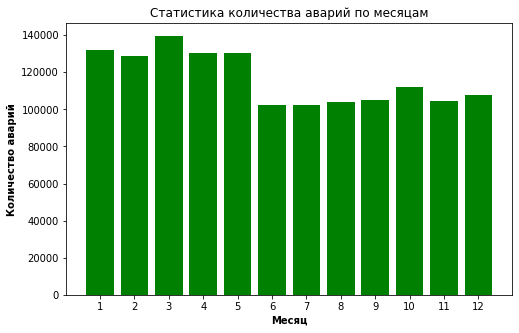

In [ ]:
df = run_sql('''
SELECT EXTRACT (MONTH FROM collision_date::date) AS month, COUNT(case_id)
FROM public.collisions
GROUP BY EXTRACT (MONTH FROM collision_date::date)
        ''')
df
x_pos = np.arange(len(df['month']))+1
plt.figure(figsize=(8,5))
plt.bar(x_pos, df['count'], color = 'g')
plt.xticks(df['month'])
plt.xlabel('Месяц',fontweight='bold')
plt.ylabel('Количество аварий',fontweight='bold')
plt.title('Cтатистика количества аварий по месяцам')
plt.show()

**С января по май вероятность попасть в аварию на 25-40% больше, чем в период с июня по декабрь.**

In [ ]:
df = run_sql('''
SELECT DISTINCT date_trunc('month', collision_date)
FROM collisions
ORDER BY date_trunc
        ''')
df

,date_trunc
0,2009-01-01 00:00:00+03:00
1,2009-02-01 00:00:00+03:00
2,2009-03-01 00:00:00+03:00
3,2009-04-01 00:00:00+04:00
4,2009-05-01 00:00:00+04:00
5,2009-06-01 00:00:00+04:00
6,2009-07-01 00:00:00+04:00
7,2009-08-01 00:00:00+04:00
8,2009-09-01 00:00:00+04:00
9,2009-10-01 00:00:00+04:00


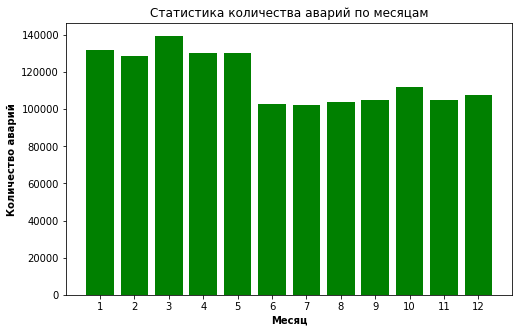

In [ ]:
df = run_sql('''
SELECT EXTRACT (MONTH FROM collision_date::date) AS month, COUNT(case_id)
FROM public.collisions
WHERE EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY EXTRACT (MONTH FROM collision_date::date)
        ''')
df
x_pos = np.arange(len(df['month']))+1
plt.figure(figsize=(8,5))
plt.bar(x_pos, df['count'], color = 'g')
plt.xticks(df['month'])
plt.xlabel('Месяц',fontweight='bold')
plt.ylabel('Количество аварий',fontweight='bold')
plt.title('Cтатистика количества аварий по месяцам')
plt.show()

Ниже проведем анализ двух примеров, которые были даны в задании проекта.

Пример 1. Проведем анализ серьезности повреждений т/c, исходя из состояния дороги в момент ДТП

In [ ]:
df = run_sql('''
SELECT c.road_condition_1, c.collision_damage, count(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type ='car' AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY c.road_condition_1, c.collision_damage
ORDER BY 3 DESC
        ''')
df

,road_condition_1,collision_damage,count
0,normal,small damage,1415258
1,normal,scratch,654454
2,normal,middle damage,249848
3,normal,severe damage,42723
4,construction,small damage,24152
5,normal,fatal,14749
6,None,small damage,11811
7,construction,scratch,9780
8,None,scratch,5835
9,obstruction,small damage,5482


**Больше всего аварий автомобилей случается, когда состояние проезжей части находится в обычном состоянии, т.е. на ней не производятся ремонтных работ, на ней не находится какие-то препятствия и т.д. При таких авариях автомобили получают малые повреждения, царапины, средние повреждения. Реже при таких авариях автомобили получают серьезные повреждения, еще реже авто после таких аварий не подлежит восстановлению.**

**Из анамального состояния проезжей части можно выделить, состояние когда на ней производится ремонтные работы. При ремонтных работах автомобили получают малые повреждения и царапины.**

Пример 2. Найдем самые частые причины ДТП

In [ ]:
df = run_sql('''
SELECT c.pcf_violation_category, COUNT(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type = 'car' AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY c.pcf_violation_category
ORDER BY count DESC
        ''')
df

,pcf_violation_category,count
0,speeding,901241
1,improper turning,319616
2,automobile right of way,313354
3,unsafe lane change,193682
4,dui,155371
5,traffic signals and signs,145760
6,unsafe starting or backing,90045
7,following too closely,66487
8,unknown,61485
9,wrong side of road,47761


**Наиболее частое нарушение при котором происходит ДТП это несоблюдение скоростного режима, далее идет неправильное маневрирование при поворотах(разворотах), затем не соблюдение преимущества(права проезда) и далее это перестроение(маневрирование) при смене полосы движения.**

Далее самостоятельно сформулируем шесть задач.

**ЗАДАЧА 1.**
Найти количество аварий, в которых участвовали автомобили в зависимости от дня недели.

,day,count
0,1.0,346221
1,2.0,377363
2,3.0,376601
3,4.0,376665
4,5.0,413800
5,6.0,318653
6,7.0,259575


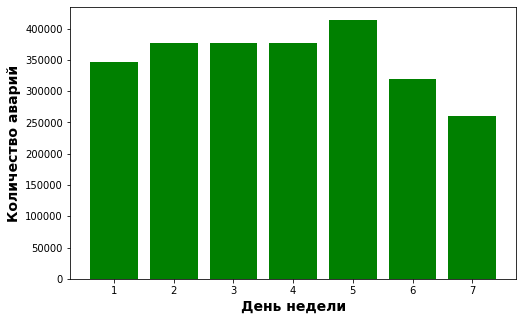

In [ ]:
df = run_sql('''
SELECT EXTRACT (isodow FROM c.collision_date ) as day, count(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type = 'car' AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY EXTRACT (isodow FROM c.collision_date )
        ''')
display(df)
plt.figure(figsize = (8,5))
plt.bar(df['day'], df['count'], color='g')
plt.xlabel('День недели', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')

plt.show()

**Больше всего аварий происходит в пятницу. Среди будних дней  самый безаварийный - это понедельник. На выходных происходит меньше аварий, чем в будни. Самый безаварийный день недели - воскресенье.**

**ЗАДАЧА 2.** Как влияет возраст автомобиля на вероятность попасть в аварию. Учесть только авто, чей возраст менее или равен 20 годам.

,vehicle_age,count
0,0,82895
1,1,80873
2,2,197135
3,3,340053
4,4,247706
5,5,212057
6,6,171190
7,7,169873
8,8,155122
9,9,117084


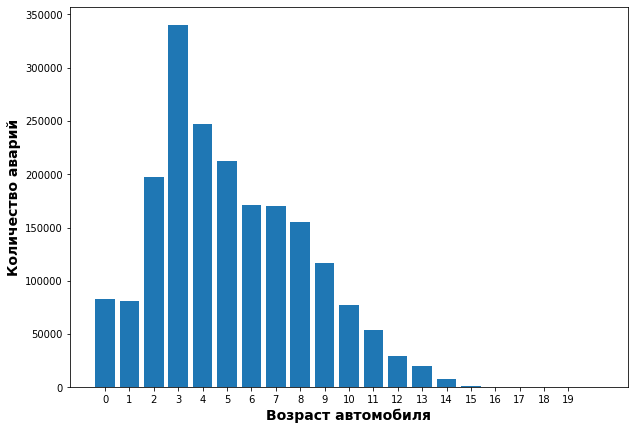

In [ ]:
df = run_sql('''
SELECT v.vehicle_age, count(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
LEFT JOIN vehicles v ON v.case_id = c.case_id
WHERE p.party_type = 'car'  AND v.vehicle_age IS NOT NULL AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY v.vehicle_age
HAVING v.vehicle_age <=20
        ''')
display(df)
plt.figure(figsize=(10,7))
plt.bar(df['vehicle_age'], df['count'])
plt.xticks(np.arange(20))
plt.xlabel('Возраст автомобиля', fontweight = 'bold', fontsize='14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize='14')
plt.show()

**Меньше всего аварий происходит с новыми авто, чей возраст до одного года. Больше всего аварий происходит с трехлетними автомобилями.**

**По возрасту авто можно выделить, следующие категории:**
 - **менее двух лет и более 10 лет - низкая аварийность**
 - **от двух до пяти лет - высокая аварийность**
 - **от шести до девяти лет - средняя аварийность**


**ЗАДАЧА 3.** Как меняется количество аварий в зависимости от времени суток.

,hour,count
0,0.0,35432
1,1.0,33923
2,2.0,36050
3,3.0,22612
4,4.0,19636
5,5.0,30976
6,6.0,57961
7,7.0,133929
8,8.0,141941
9,9.0,107688


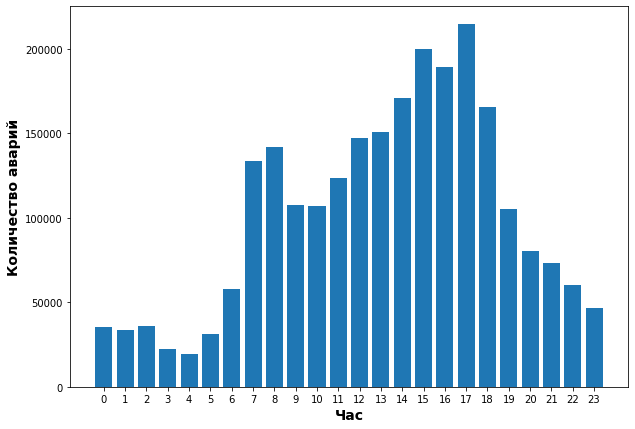

In [ ]:
df = run_sql('''
SELECT EXTRACT (HOUR FROM collision_time) AS hour, COUNT(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type  = 'car' AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY EXTRACT (HOUR FROM collision_time)
HAVING EXTRACT (HOUR FROM collision_time) IS NOT NULL
        ''')
display(df)
plt.figure(figsize=(10,7))
plt.bar(df['hour'], df['count'])
plt.xticks(np.arange(len(df)))
plt.xlabel('Час', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**С 23:00 до 06:00 происходит наименьшее количество аварий**

**С 07:00 до 17:00 идет стремительное нарастание количества аварий с каждым часом, за исключение промежутка с 09:00 до 10:00, где наблюдаетмя локальный минимум.**

**С 18:00 до 22:00 происходит резкий спад от часа к часу**

**Задача 4.** В каких местах(location_type) более часто попадают в аварии автомобили?

In [ ]:
df = run_sql('''
SELECT c.location_type, count(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type  = 'car' AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY c.location_type
ORDER BY 2 DESC
        ''')
display(df)

,location_type,count
0,None,1462288
1,highway,822124
2,ramp,134135
3,intersection,50331


**На первом месте по количеству аварий идут "пустые значения", скорее всего это вполне обычные участки дороги ничем не примечательные. На втором месте по количеству аварий идут автомагистрали, на третьем развязки(съезды), на четвертом перекрестки**

**Задача 5.** В каких местах(county_location) более часто попадают в аварии автомобили? Найти десять с городов, в которых происходят больше всего аварий.

In [ ]:
df = run_sql('''
SELECT c.county_location, count(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type  = 'car' AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY c.county_location
ORDER BY 2 DESC
LIMIT 10
        ''')
display(df)

,county_location,count
0,los angeles,790595
1,orange,221984
2,san bernardino,140993
3,san diego,137574
4,riverside,123921
5,alameda,114131
6,sacramento,106489
7,santa clara,93843
8,contra costa,55534
9,ventura,55410


**Больше всего аварий происходит в Лос-Анджелесе, на втором месте Оранж, на третьем Сан-Бернардиньо. Для оценки самых аварийных городов требуется знать общее количество авто зарегистрированных в этих городах и произвести расчет статистики аварий скажет на 100 000 зарегистрированных автомобилей**

**Задача 6.** Как влияют погодные условия (weather_1) на количество аварий? Для установленных виновников ДТП и только для автомобилей.

In [ ]:
df = run_sql('''
SELECT c.weather_1, count(*)
FROM collisions c
LEFT JOIN parties p ON p.case_id = c.case_id
WHERE p.party_type  = 'car' AND p.at_fault = 1 AND EXTRACT (YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY c.weather_1
ORDER BY 2 DESC
        ''')
display(df)

,weather_1,count
0,clear,988932
1,cloudy,184211
2,raining,52921
3,fog,5592
4,None,4707
5,snowing,2349
6,other,1100
7,wind,320


**Больше всего аварий происходит как не странно в ясную погоду, далее по количеству аварий идет пасмурная и облачная погода, на третьем месте идет дождливая погода.**

**ВЫВОД**

**С января по май вероятность попасть в аварию на 25-40% больше, чем в период с июня по декабрь.**

**Больше всего аварий автомобилей случается, когда состояние проезжей части находится в обычном состоянии, т.е. на ней не производятся ремонтных работ, на ней не находится какие-то препятствия и т.д. При таких авариях автомобили получают малые повреждения, царапины, средние повреждения. Реже при таких авариях автомобили получают серьезные повреждения, еще реже авто после таких аварий не подлежит восстановлению.**

**Из анамального состояния проезжей части можно выделить, состояние когда на ней производится ремонтные работы. При ремонтных работах автомобили получают малые повреждения и царапины.**


**Наиболее частое нарушение при котором происходит ДТП это несоблюдение скоростного режима, далее идет неправильное маневрирование при поворотах(разворотах), затем не соблюдение преимущества(права проезда) и далее это перестроение(маневрирование) при смене полосы движения.**


**Больше всего аварий происходит в пятницу. Среди будних дней  самый безаварийный - это понедельник. На выходных происходит меньше аварий, чем в будни. Самый безаварийный день недели - воскресенье.**


**Меньше всего аварий происходит с новыми авто, чей возраст до одного года. Больше всего аварий происходит с трехлетними автомобилями.**

**По возрасту авто можно выделить, следующие категории:**
 - **менее двух лет и более 10 лет - низкая аварийность**
 - **от двух до пяти лет - высокая аварийность**
 - **от шести до девяти лет - средняя аварийность**


**С 23:00 до 06:00 происходит наименьшее количество аварий**

**С 07:00 до 17:00 идет стремительное нарастание количества аварий с каждым часом, за исключение промежутка с 09:00 до 10:00, где наблюдаетмя локальный минимум.**

**С 18:00 до 22:00 происходит резкий спад от часа к часу**


**На первом месте по количеству аварий идут "пустые значения", скорее всего это вполне обычные участки дороги ничем не примечательные. На втором месте по количеству аварий идут автомагистрали, на третьем развязки(съезды), на четвертом перекрестки**


**Больше всего аварий происходит в Лос-Анджелесе, на втором месте Оранж, на третьем Сан-Бернардиньо. Для оценки самых аварийных городов требуется знать общее количество авто зарегистрированных в этих городах и произвести расчет статистики аварий скажет на 100 000 зарегистрированных автомобилей**


**Больше всего аварий происходит как не странно в ясную погоду, далее по количеству аварий идет пасмурная и облачная погода, на третьем месте идет дождливая погода.**







## Шаг 4. Создайте модель для оценки водительского риска

#### 4.1 Подготовим набор данных на основе первичного предположения заказчика:
 - выберем тип виновника - только машина;
 - возьмем случаи, когда ДТП привело к любым значимым значимым повреждениям авто любого из участников - все, кроме типа SCRATCH;
 - для моделирования возьмем данные только за 2012 год;
 - подготовка исходной таблицы будет проводиться с помощью sql - запроса

In [ ]:
df = run_sql ('''
SELECT *
FROM collisions AS c
LEFT JOIN parties AS p ON p.case_id = c.case_id
LEFT JOIN vehicles AS v ON v.case_id = c.case_id
WHERE  EXTRACT(YEAR FROM c.collision_date) = 2012 AND p.party_type = 'car' AND c.collision_damage != 'scratch'
    ''')

df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5449178,4806,solano,328.0,north,0.0,clear,None,small damage,1,...,58.0,had not been drinking,None,0.0,NaN,None,NaN,None,None,NaN
1,5454075,3000,orange,900.0,north,0.0,clear,None,small damage,2,...,65.0,had not been drinking,None,0.0,NaN,None,NaN,None,None,NaN
2,5454105,3015,orange,50.0,north,0.0,clear,highway,small damage,2,...,61.0,had not been drinking,None,0.0,1325817.0,5454105,1.0,sedan,manual,5.0
3,5454105,3015,orange,50.0,north,0.0,clear,highway,small damage,2,...,61.0,had not been drinking,None,0.0,1325818.0,5454105,2.0,sedan,manual,9.0
4,5457855,3496,sacramento,25.0,east,0.0,raining,None,small damage,3,...,24.0,None,None,NaN,NaN,None,NaN,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226979,5456453,1900,los angeles,700.0,north,0.0,clear,highway,small damage,3,...,25.0,had not been drinking,None,0.0,NaN,None,NaN,None,None,NaN
226980,5456453,1900,los angeles,700.0,north,0.0,clear,highway,small damage,3,...,57.0,had not been drinking,None,0.0,NaN,None,NaN,None,None,NaN
226981,5456459,1941,los angeles,0.0,None,NaN,clear,None,small damage,3,...,56.0,None,impairment - physical,NaN,NaN,None,NaN,None,None,NaN
226982,5456459,1941,los angeles,0.0,None,NaN,clear,None,small damage,3,...,48.0,had not been drinking,None,NaN,NaN,None,NaN,None,None,NaN


In [ ]:
df.shape

(226984, 35)

#### 4.2 Проведем первичный отбор факторов, необходимых для модели.

In [ ]:
df.columns

Index(['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time', 'id',
       'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'id', 'case_id', 'party_number', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [ ]:
df1 = df

'case_id',                 #  номер случая в базе данны для модели не нужен


'county_city_location',   # состоит из цифровых категориальных переменных, предположительно первые две цифры означают                                        населенных пункт, вторые две означают номер района в городе. Для модели не будем использовать этот                              признак, т.к. содержит большое количество категориальных переменных, что усложняет модель. Вместо                                этого используем более укрупненный признак только название населенного пункта 'county_location'



 'county_location',       # содержит название населенного пункта. Этот признак точно может влиять, т.к. в более крупных городах                             вероятность попасть в ДТП выше, чем скажем в маленьком городе.



 'distance',              # расстояние от главной дороги. Этот признак на мой взгляд не может влиять на вероятность ДТП, т.к.
                            его тяжело будет применить к маршруту следования клиента.



 'direction',             # может влиять, так как мы знаем маршрут следования клиента, а значит будем знать и направление и это                           можно будет применить в модели.



 'intersection',          # булевская переменная показывающая произошла авария на перекрестке или нет. Подрозумевает, что авария                            уже произошла, поэтому не применима для нашей модели.

 'weather_1',             # этот признак, точно может влиять на вероятность ДТП, так как в плохих погодных условиях вероятность                            попасть в ДТП выше.


 'location_type',         # показывает, где уже произошла авария, чего мы заранее знать не можем. Не будем применять.


 'collision_damage',      # повреждения полученные в аварии. Не будем применять в модели, так как мы заранее не знаем будет                                 авария или нет.

 'party_count',           # количество участников в аварии. Не будем применять в модели, так как мы заранее не знаем будет                                   авария или нет.


 'primary_collision_factor', # Не будем применять в модели, так как мы заранее не знаем будет                                                                  авария или нет.


 'pcf_violation_category',    # Не будем применять в модели, так как мы заранее не знаем из-за какого нарушения произойдет                                      авария



 'type_of_collision',         # Не будем применять в модели, так как мы заранее не знаем будет                                                                  авария или нет.


 'motor_vehicle_involved_with',   # Не будем применять в модели, так как мы заранее не знаем будет                                                                  авария или нет.



 'road_surface',             # Точно влияет на вероятность попасть в ДТП, т.к на влажной дороге вероятность попасть в ДТП выше.



 'road_condition_1',        # Этот признак можно использовать в модели, т.к. зная маршрут мы можем узнать, есть на маршруте                                   ремонт дороги, сужение дороги, препятствия, а эти факторы могут влиять на вероятность ДТП



 'lighting',              # Освещение точно может влиять на вероятность ДТП


 'control_device',        # Может влиять на вероятность ДТП, так как водитель зная, что в его авто установлено устройство                                  контроля будет стараться управлять авто более аккуратно.


 'collision_date',       # Может влиять на вероятность ДТП, так как в примерах задач разобранных раньше в этом проекте в разные                           месяцы происходят разное количество аварий, а также в разные дни недели происходит разное количество                             аварий. В дальнейшем будем использовать номер месяца и номер дня недели в нашей модели.


 'collision_time',       # Может влиять на вероятность ДТП, так как в разное время суток происходит разное количество аварий, в                            дальнейшем будем использовать только час.



 'id',                   #  номер случая в базе данны для модели не нужен


 'case_id',              #  номер случая в базе данны для модели не нужен



 'party_number',          # номер участника в аварии. Не будем применять в модели, так как мы заранее не знаем будет                                        авария или нет.


 'party_type',           # Не будем использовать в нашей модели, так как данные в датасете содержат только участников типа =                               'car'    

  
 'at_fault',              # Целевая переменная




 'insurance_premium',     # Cумма выплаченная клиенту после аварии. Не будем применять в модели, так как мы заранее не знаем                                 будет авария или нет.



 'party_sobriety',       # Трезвость - точно может влиять на вероятность ДТП


 'party_drug_physical',   # Физическое состояние водителя точно может влиять вероятность ДТП



 'cellphone_in_use',      # Возможность водителя разговаривать по громкой связи может влиять на вероятность ДТП, т.к. разговор                              по телефону во время движения увеличивает вероятность ДТП.



 'id',                    #  номер случая в базе данны для модели не нужен


 'case_id',               #  номер случая в базе данны для модели не нужен




 'party_number',          # номер участника в аварии. Не будем применять в модели, так как мы заранее не знаем будет                                        авария или нет.


 'vehicle_type',          # Тип кузова авто может влиять на вероятность ДТП, так как более крупными авто тяжелее управлять, чем                             более компактными.



 'vehicle_transmission',  # Тип трансмиссия может влиять, т.к. авто с автоматической трансмиссией более комфортна в управлении



 'vehicle_age'            # По заданию от заказчика модель должна учитывать возраст авто, значит будем использовать в нашей                                модели


Удалим столбы, согласно приведенным выше заключениям.

In [ ]:
df = df.drop(['case_id', 'county_city_location', 'distance', 'intersection', 'location_type', 'collision_damage',\
             'party_count', 'primary_collision_factor', 'pcf_violation_category', \
             'type_of_collision', 'motor_vehicle_involved_with', 'id', 'case_id', 'party_number',\
             'party_type', 'insurance_premium'], axis = 1)

In [ ]:
df.head()

,county_location,direction,weather_1,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,solano,north,clear,dry,normal,daylight,none,2012-01-18,11:21:00,1,had not been drinking,None,0.0,None,None,NaN
1,orange,north,clear,dry,normal,daylight,none,2012-01-26,08:50:00,0,had not been drinking,None,0.0,None,None,NaN
2,orange,north,clear,dry,normal,daylight,none,2012-01-31,14:02:00,1,had not been drinking,None,0.0,sedan,manual,5.0
3,orange,north,clear,dry,normal,daylight,none,2012-01-31,14:02:00,1,had not been drinking,None,0.0,sedan,manual,9.0
4,sacramento,east,raining,wet,normal,daylight,none,2012-01-23,10:20:00,1,None,None,NaN,None,None,NaN


#### 4.3 Проведем статистическое исследование отобранных факторов.

In [ ]:
df['county_location'].value_counts()[:10]

los angeles       74004
orange            21717
san bernardino    13410
riverside         12618
san diego         12067
alameda            9085
sacramento         8722
santa clara        8085
ventura            5694
kern               4920
Name: county_location, dtype: int64

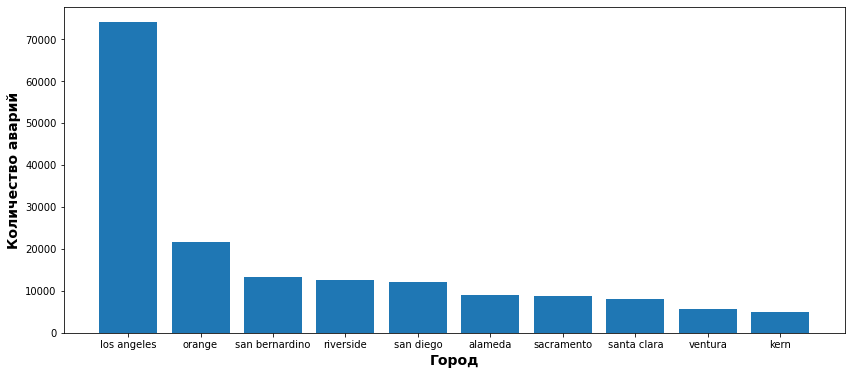

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(df['county_location'].value_counts()[:10].index, df['county_location'].value_counts()[:10].values)
plt.xlabel('Город', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Лос-Анджелес существенно лидирует по количеству аварий среди других городов.**

In [ ]:
df['direction'].value_counts()

north    49248
south    48754
west     39215
east     38517
Name: direction, dtype: int64

In [ ]:
df['direction'].value_counts().values[3] / df['direction'].value_counts().values[1]

0.7900274849243138

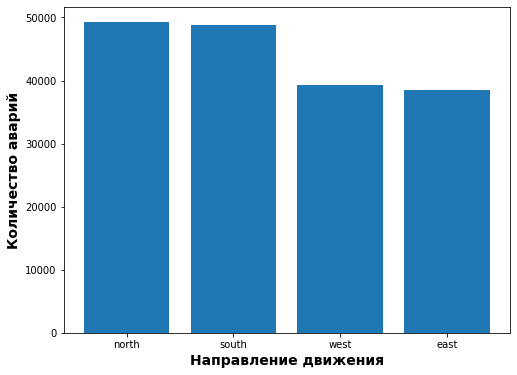

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(df['direction'].value_counts().index, df['direction'].value_counts().values)
plt.xlabel('Направление движения', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**В северном и южном направлении движения количество аварий примерно на 20% больше, чем на восточном и западном.**

In [ ]:
df['weather_1'].value_counts()

clear      182055
cloudy      33672
raining      9044
fog           698
snowing       492
other         188
wind           56
Name: weather_1, dtype: int64

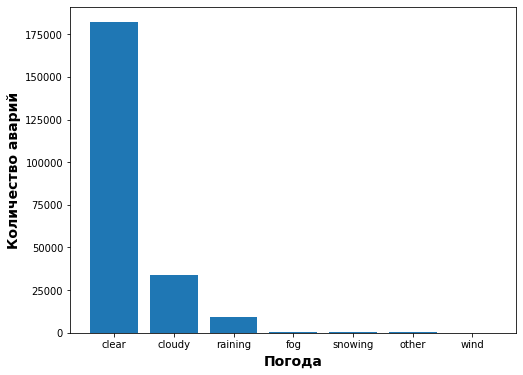

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(df['weather_1'].value_counts().index, df['weather_1'].value_counts().values)
plt.xlabel('Погода', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**В ясную погоду как не странно происходит больше всего аварий, затем по количеству аварий идет облачная погода, затем дождливая**

In [ ]:
df['road_surface'].value_counts()

dry         203077
wet          21219
snowy         1034
slippery       162
Name: road_surface, dtype: int64

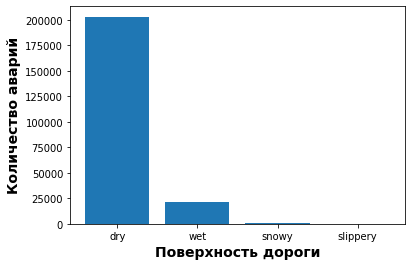

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(df['road_surface'].value_counts().index, df['road_surface'].value_counts().values)
plt.xlabel('Поверхность дороги', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Больше всего аварий происходит на дорогах с сухими покрытиями, второе по количеству аварий влажное покрытие.**

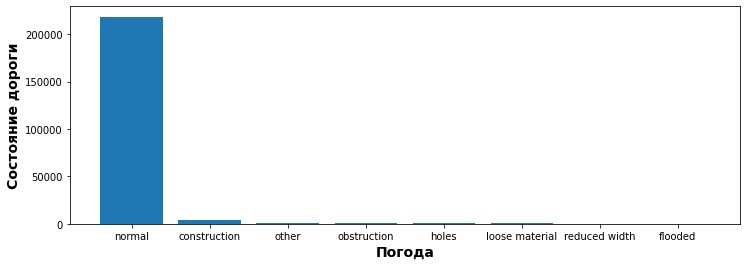

In [ ]:
df['road_condition_1'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['road_condition_1'].value_counts().index, df['road_condition_1'].value_counts().values)
plt.xlabel('Погода', fontweight = 'bold', fontsize = '14')
plt.ylabel('Состояние дороги', fontweight = 'bold', fontsize = '14')
plt.show()

**Больше всего аварий происходит на дорогах, когда они находятся в нормальном состоянии, на втором месте дороги, на которых ведутся ремонтные работы или строительство**

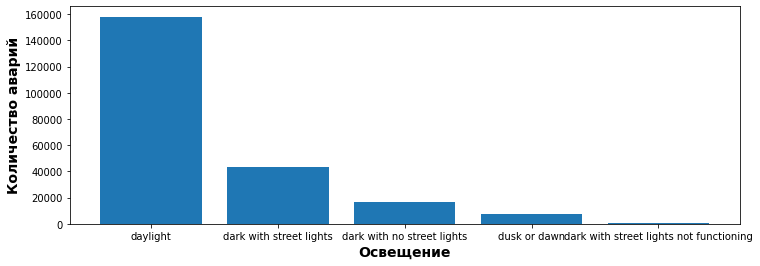

In [ ]:
df['lighting'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['lighting'].value_counts().index, df['lighting'].value_counts().values)
plt.xlabel('Освещение', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Больше всего аварий происходит в дневное время с нормальным освещением, на втором месте в темное время суток с уличным освещением**

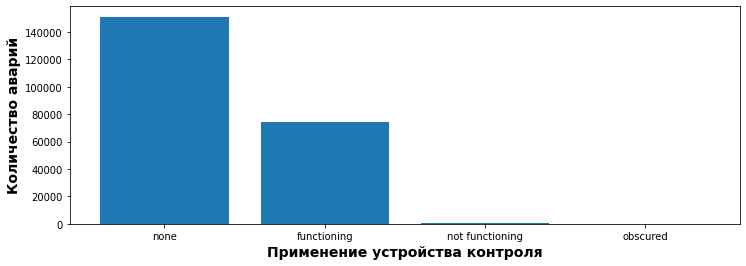

In [ ]:
df['control_device'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['control_device'].value_counts().index, df['control_device'].value_counts().values)
plt.xlabel('Применение устройства контроля', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Больше всего аварий происходит, тогда когда устройство контроля отсутсвовало**

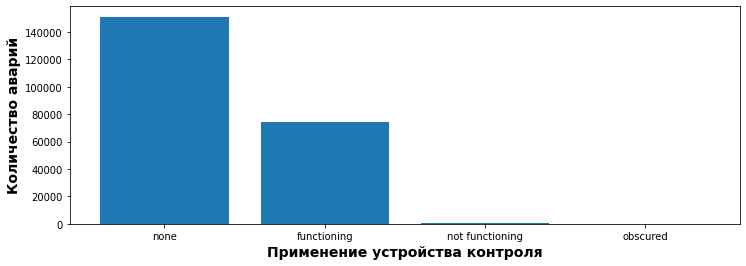

In [ ]:
df['control_device'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['control_device'].value_counts().index, df['control_device'].value_counts().values)
plt.xlabel('Применение устройства контроля', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Статистика аварий по месяцам, дню недели и времени суток была проведена ранее в этом проекте. В дальнейшем из `collision_date` выделим номер месяца и день недели, а из `collision_time` выделим только час**

In [ ]:
df['collision_date'] = pd.to_datetime(df['collision_date'], format='%Y-%m-%d')
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')

df['month'] = pd.DatetimeIndex(df['collision_date']).month
df['dow'] = pd.DatetimeIndex(df['collision_date']).dayofweek
df['hour'] = pd.DatetimeIndex(df['collision_time']).hour
df[['collision_date', 'month', 'dow', 'collision_time','hour']][:5]



,collision_date,month,dow,collision_time,hour
0,2012-01-18,1,2,1900-01-01 11:21:00,11.0
1,2012-01-26,1,3,1900-01-01 08:50:00,8.0
2,2012-01-31,1,1,1900-01-01 14:02:00,14.0
3,2012-01-31,1,1,1900-01-01 14:02:00,14.0
4,2012-01-23,1,0,1900-01-01 10:20:00,10.0


In [ ]:
df = df.drop(['collision_date', 'collision_time'], axis = 1)

In [ ]:
df.head()

,county_location,direction,weather_1,road_surface,road_condition_1,lighting,control_device,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,month,dow,hour
0,solano,north,clear,dry,normal,daylight,none,1,had not been drinking,None,0.0,None,None,NaN,1,2,11.0
1,orange,north,clear,dry,normal,daylight,none,0,had not been drinking,None,0.0,None,None,NaN,1,3,8.0
2,orange,north,clear,dry,normal,daylight,none,1,had not been drinking,None,0.0,sedan,manual,5.0,1,1,14.0
3,orange,north,clear,dry,normal,daylight,none,1,had not been drinking,None,0.0,sedan,manual,9.0,1,1,14.0
4,sacramento,east,raining,wet,normal,daylight,none,1,None,None,NaN,None,None,NaN,1,0,10.0


In [ ]:
df['at_fault'].value_counts()


1    114775
0    112209
Name: at_fault, dtype: int64

In [ ]:
(df['at_fault'].value_counts().values[0] - df['at_fault'].value_counts().values[1])*100/df['at_fault'].value_counts().values[0]

2.2356785014158134

**Дисбаланс целевой переменной составляет всего 2%, будем считать что она сбалансирована**

In [ ]:
df['party_sobriety'].value_counts()

had not been drinking                     185118
impairment unknown                         21248
had been drinking, under influence         11425
had been drinking, impairment unknown       1791
not applicable                              1789
had been drinking, not under influence      1589
Name: party_sobriety, dtype: int64

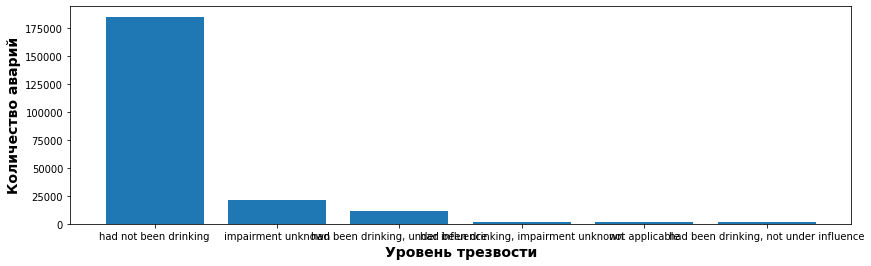

In [ ]:

plt.figure(figsize=(14,4))
plt.bar(df['party_sobriety'].value_counts().index, df['party_sobriety'].value_counts().values)
plt.xlabel('Уровень трезвости', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Большинство аварий происходит, когда водители находились в трезвом состоянии. На втором месте, когда влияние алкоголя было неизвестно, на третьем месте  - когда водители употребляли алгоколь и находились под его влиянием.**

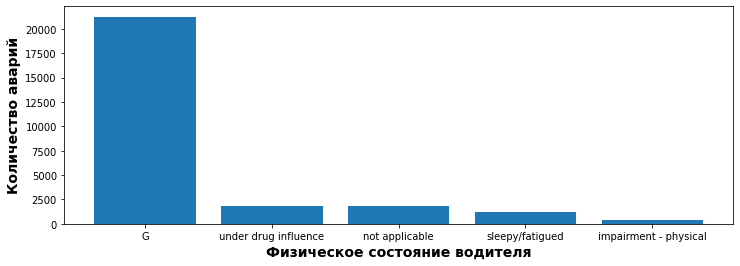

In [ ]:
df['party_drug_physical'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['party_drug_physical'].value_counts().index, df['party_drug_physical'].value_counts().values)
plt.xlabel('Физическое состояние водителя', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Больше всего аварий происходило, когда на состояние водителя не влияли медикаменты**

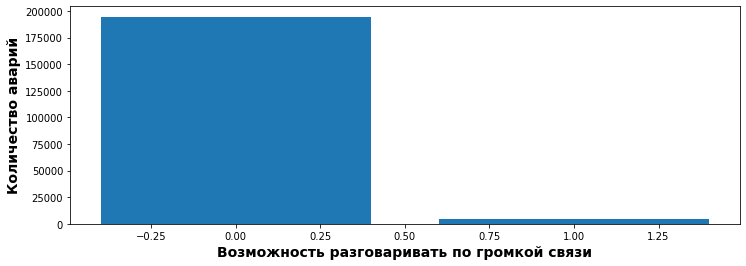

In [ ]:
df['cellphone_in_use'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['cellphone_in_use'].value_counts().index, df['cellphone_in_use'].value_counts().values)
plt.xlabel('Возможность разговаривать по громкой связи', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Большинство аварий происходило, когда в автомобиле не было устройства громкой связи**

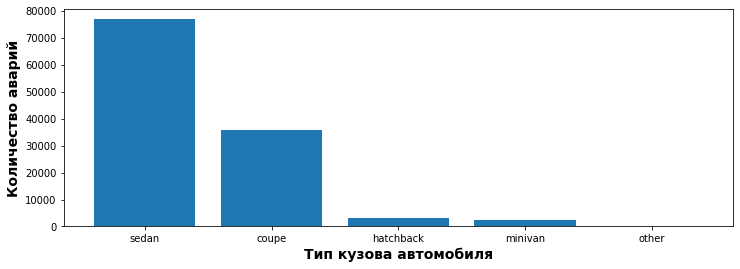

In [ ]:
df['vehicle_type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['vehicle_type'].value_counts().index, df['vehicle_type'].value_counts().values)
plt.xlabel('Тип кузова автомобиля', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

**Чаще других в аварии попадают авто с типом кузова седан и купе, реже хэтчбеки и миниваны**

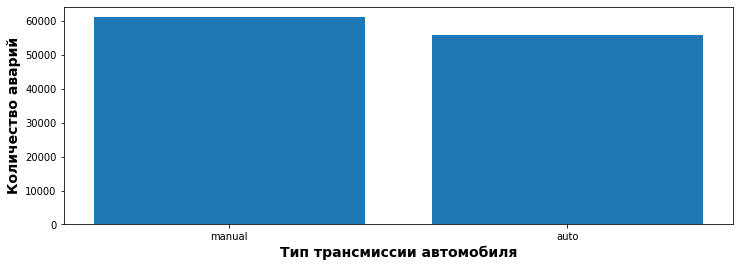

In [ ]:
df['vehicle_transmission'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(df['vehicle_transmission'].value_counts().index, df['vehicle_transmission'].value_counts().values)
plt.xlabel('Тип трансмиссии автомобиля', fontweight = 'bold', fontsize = '14')
plt.ylabel('Количество аварий', fontweight = 'bold', fontsize = '14')
plt.show()

In [ ]:
(df['vehicle_transmission'].value_counts().values[0] - df['vehicle_transmission'].value_counts().values[1])*100/df['vehicle_transmission'].value_counts().values[0]

8.73568122887058

**Количество аварий, в которые попали автомобили с механической трансмиссией на 8% больше, чем у автомобилей с автоматической коробкой**

**Меньше всего аварий происходит с новыми авто, чей возраст до одного года. Больше всего аварий происходит с трехлетними автомобилями.**

**По возрасту авто можно выделить, следующие категории:**
 - **менее двух лет и более 10 лет - низкая аварийность**
 - **от двух до пяти лет - высокая аварийность**
 - **от шести до девяти лет - средняя аварийность**

**ВЫВОД**

**Лос-Анджелес существенно лидирует по количеству аварий среди других городов.**

**В северном и южном направлении движения количество аварий примерно на 20% больше, чем на восточном и западном.**

**В ясную погоду как не странно происходит больше всего аварий, затем по количеству аварий идет облачная погода, затем дождливая**

**Больше всего аварий происходит на дорогах с сухими покрытиями, второе по количеству аварий влажное покрытие.**

**Больше всего аварий происходит на дорогах, когда они находятся в нормальном состоянии, на втором месте дороги, на которых ведутся ремонтные работы или строительство**


**Больше всего аварий происходит в дневное время с нормальным освещением, на втором месте в темное время суток с уличным освещением**


**Больше всего аварий происходит, тогда когда устройство контроля отсутсвовало**


**Дисбаланс целевой переменной составляет всего 2%, будем считать что она сбалансирована**

**Большинство аварий происходит, когда водители находились в трезвом состоянии. На втором месте, когда влияние алкоголя было неизвестно, на третьем месте  - когда водители употребляли алгоколь и находились под его влиянием.**


**Большинство аварий происходило, когда в автомобиле не было устройства громкой связи**


**Чаще других в аварии попадают авто с типом кузова седан и купе, реже хэтчбеки и миниваны**

**Количество аварий, в которые попали автомобили с механической трансмиссией на 8% больше, чем у автомобилей с автоматической коробкой**



**Меньше всего аварий происходит с новыми авто, чей возраст до одного года. Больше всего аварий происходит с трехлетними автомобилями.**

**По возрасту авто можно выделить, следующие категории:**
 - **менее двух лет и более 10 лет - низкая аварийность**
 - **от двух до пяти лет - высокая аварийность**
 - **от шести до девяти лет - средняя аварийность**













In [ ]:
df.describe()

,at_fault,cellphone_in_use,vehicle_age,month,dow,hour
count,226984.000000,199291.000000,115046.000000,226984.000000,226984.000000,225598.000000
mean,0.505652,0.023393,4.908263,3.107166,2.933643,13.145897
std,0.499969,0.151148,3.266265,1.682418,1.918591,5.354235
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,2.000000,1.000000,9.000000
50%,1.000000,0.000000,4.000000,3.000000,3.000000,14.000000
75%,1.000000,0.000000,7.000000,4.000000,4.000000,17.000000
max,1.000000,1.000000,161.000000,12.000000,6.000000,23.000000


In [ ]:
df.isna().sum()

county_location              0
direction                51250
weather_1                  779
road_surface              1492
road_condition_1          1306
lighting                   807
control_device            1079
at_fault                     0
party_sobriety            4024
party_drug_physical     200553
cellphone_in_use         27693
vehicle_type            108573
vehicle_transmission    110439
vehicle_age             111938
month                        0
dow                          0
hour                      1386
dtype: int64

Категориальные признаки `direction`, `weather_1`, `road_surface`, `road_condition_1`, `lighting`, `control_device`, `party_sobriety`, `party_drug_physical`,`cellphone_in_use`,`vehicle_type`, `vehicle_transmission` содержат незаполненные значения. Заполним их значением `not_listed` - не указано.

In [ ]:
df.loc[df['cellphone_in_use'] == 0, 'cellphone_in_use'] = '0'
df.loc[df['cellphone_in_use'] == 1, 'cellphone_in_use'] = '1'

In [ ]:
list_fillna = ['direction', 'weather_1', 'road_surface', 'road_condition_1', \
               'lighting', 'control_device', 'party_sobriety', 'party_drug_physical','cellphone_in_use',\
               'vehicle_type', 'vehicle_transmission', ]

def fillna_(list_):
    for col in list_:
        df[col] = df[col].fillna('not_listed')


fillna_(list_fillna)

In [ ]:
df.isna().sum()

county_location              0
direction                    0
weather_1                    0
road_surface                 0
road_condition_1             0
lighting                     0
control_device               0
at_fault                     0
party_sobriety               0
party_drug_physical          0
cellphone_in_use             0
vehicle_type                 0
vehicle_transmission         0
vehicle_age             111938
month                        0
dow                          0
hour                      1386
dtype: int64

Теперь поработаем с признаком `vehicle_age`, который тоже содержит незаполненные значения.

In [ ]:
df['vehicle_age'].value_counts().sort_index()

0.0       6741
1.0       5701
2.0      12818
3.0      21623
4.0      14618
5.0      11781
6.0       8514
7.0       8344
8.0       7672
9.0       6106
10.0      4305
11.0      3020
12.0      1889
13.0      1195
14.0       607
15.0        81
16.0        20
17.0         6
19.0         1
161.0        4
Name: vehicle_age, dtype: int64

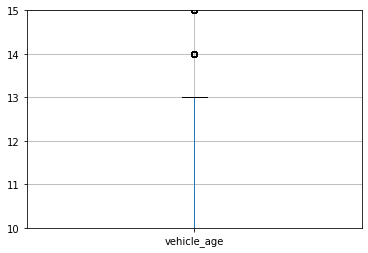

In [ ]:
df.boxplot('vehicle_age')
plt.ylim(10,15)
plt.show()

Признак `vehicle_age` содержит выборосы. Удалим строки из датасета, где `vehicle_age` > 13

In [ ]:
df = df.drop(index = df.loc[df['vehicle_age']>13].index)

In [ ]:
df['vehicle_age'].isna().sum()

111938

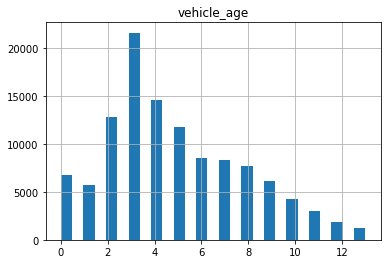

In [ ]:
df.hist('vehicle_age', bins = 27)
plt.show()

Переменная `vehicle_age` содержит довольно много пропусков 111938. Заполним эти пропуски значениями с помощью функции, которая сохранит распределение этой переменной таким же.

In [ ]:
def fill_with_same_distribution(df, col):
    count_to_fill = df[col].isna().sum() # количество незаполненных значений
    index_nan = df[df[col].isna()].index.to_list()  # cписок индексов строк, где значение не заполнено.
    list_mis = (df[col].value_counts(normalize=True).sort_index()*(count_to_fill)).round()
    ''' в этом списке для каждого значения
    будет рассчитано, сколько раз это значение нужно будет заполнить. Индекс в списке будет совпадать со значениями, т.к.
    возраст авто идет по порядку от 0 до 13. В lis_mis будут сформированы значения, к примеру [120, 240, 360...] т.е.
    значение 0 лет (индекс 0) нужно будет заполнить 120 раз, значение 1 год (индекс 1) нужно будет заполнить 240 раз,
    значение 2 года (индекс 2) нужно будет заполнить 360 раз и так далее. Из списка index_nan случайным образом будем брать
    значения индекса где есть пропуск, заполнять это значение и считать количество раз(это значение в списке list_mis, и далее
    удалять значение индекса из списка index_nan
    '''

    if (sum(list_mis) - count_to_fill) > 0:
        list_mis[0] = list_mis[0] - abs(sum(list_mis) - count_to_fill)
    elif (sum(list_mis) - count_to_fill) < 0:
         list_mis[0] = list_mis[0] + abs(sum(list_mis) - count_to_fill)
    for i in range(len(list_mis)):  # два вложенных цикла выполняют заполнение
        for j in range(int(list_mis[i])):
            random.seed(10)
            r = random.choice(index_nan)
            df.loc[r,col] = i
            index_nan.remove(r)

In [ ]:
fill_with_same_distribution(df, 'vehicle_age')

Проверим осталось ли распределение таким же после заполнения.

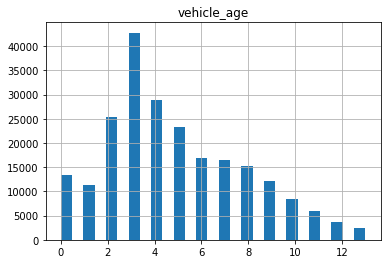

In [ ]:
df.hist('vehicle_age', bins = 27)
plt.show()

In [ ]:
df['vehicle_age'].isna().sum()

0

Все значения в `vehicle_age` заполнены. Аналогично заполним `hour`

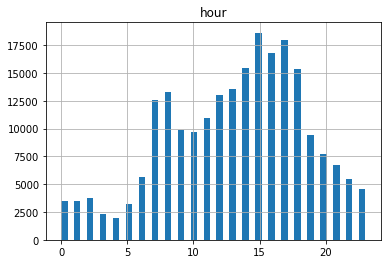

In [ ]:
df.hist('hour', bins=47)
plt.show()

In [ ]:
fill_with_same_distribution(df, 'hour')

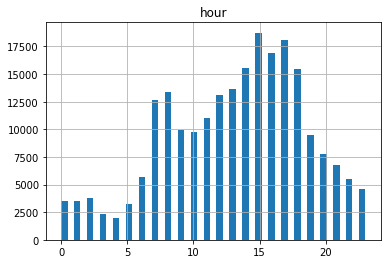

In [ ]:
df.hist('hour', bins=47)
plt.show()

In [ ]:
df['hour'].isna().sum()

0

In [ ]:
df.isna().sum()

county_location         0
direction               0
weather_1               0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
at_fault                0
party_sobriety          0
party_drug_physical     0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
month                   0
dow                     0
hour                    0
dtype: int64

In [ ]:
df.columns

Index(['county_location', 'direction', 'weather_1', 'road_surface',
       'road_condition_1', 'lighting', 'control_device', 'at_fault',
       'party_sobriety', 'party_drug_physical', 'cellphone_in_use',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age', 'month', 'dow',
       'hour'],
      dtype='object')

Датасет `df` не содержит пропусков.

Разделим нашу выборку на train, valid и test в пропорции 60:20:20

In [ ]:
target = df['at_fault']
features = df.drop('at_fault', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
                            features, target, test_size=0.4, random_state=1234, shuffle=True)


features_valid, features_test, target_valid, target_test = train_test_split(
                            features_valid, target_valid, test_size=0.5, random_state=1234)

In [ ]:
numeric = ['vehicle_age']

scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])



In [ ]:
features_train1 = features_train['vehicle_age']
features_valid1 = features_valid['vehicle_age']
features_test1 = features_test['vehicle_age']

features_train = features_train.drop('vehicle_age', axis=1)
features_valid = features_valid.drop('vehicle_age', axis=1)
features_test = features_test.drop('vehicle_age', axis=1)

In [ ]:
idx = features_train.index
enc = OneHotEncoder(handle_unknown = 'ignore')
features_train = enc.fit_transform(features_train).toarray()
features_train = pd.DataFrame(features_train, columns = list(flatten(enc.categories_)), index = idx)



idx = features_valid.index
enc.transform(features_valid).toarray()
features_valid = pd.DataFrame(enc.transform(features_valid).toarray(),
                              columns = list(flatten(enc.categories_)), index = idx)


idx = features_test.index
enc.transform(features_test).toarray()
features_test = pd.DataFrame(enc.transform(features_test).toarray(),
                              columns = list(flatten(enc.categories_)), index = idx)


In [ ]:
features_train['vehicle_age'] = features_train1
#features_valid['vehicle_age'] = features_valid1
#features_test['vehicle_age'] = features_test1
del(features_train1)

In [ ]:
features_valid['vehicle_age'] = features_valid1
del(features_valid1)

In [ ]:
features_test['vehicle_age'] = features_test1
del(features_test1)

## Шаг 5. Поиск лучшей модели.

В качестве метрики оценки модели будем использовать ROC_AUC,  она не зависит от дисбаланса целевой переменной.

In [ ]:
features_train_sample = features_train.sample(n=20000, random_state=1234)
target_train_sample = target_train.sample(n=20000, random_state=1234)

## Логистическая регрессия.

In [ ]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

scores = cross_val_score(model, features_train, target_train, cv=10, scoring='roc_auc', n_jobs = -1)
final_score = scores.mean()
print('Для модели ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ roc_auc = ', final_score)

In [ ]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

scores = cross_val_score(model, features_test, target_test, cv=10, scoring='roc_auc', n_jobs = -1)
final_score = scores.mean()
print('Для модели ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ roc_auc = ', final_score)

In [ ]:
log_reg_score = 0.6620

## Решающее дерево.

In [ ]:
for depth in range(1, 8, 2):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    scores = cross_val_score(model, features_train, target_train, cv=10, scoring='roc_auc', n_jobs = -1)
    final_score =scores.mean()
    f1_tree = final_score
    print(' auc_roc =', final_score, '\t depth = ', depth)

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
scores = cross_val_score(model, features_test, target_test, cv=10, scoring='roc_auc', n_jobs = -1)
final_score =scores.mean()
f1_tree = final_score
print(' auc_roc =', final_score, '\t depth = ', depth)

In [ ]:
dt_score = 0.6565

## Случайный лес.

In [ ]:
parameters = {
    'n_estimators' : [50, 100],
    'max_depth' : [11, 12],
    'max_features' : [32, 64]
}

In [ ]:
%%time
rfc = RandomForestClassifier()
gs_rfc = GridSearchCV(rfc, parameters, scoring = 'roc_auc', cv=10, n_jobs = -1)
gs_rfc.fit(features_train_sample, target_train_sample)
gs_rfc.best_params_

In [ ]:
%%time
model = RandomForestClassifier(max_depth = 11, max_features = 64, n_estimators = 50)
scores = cross_val_score(model, features_test, target_test, cv=10, scoring='roc_auc', n_jobs = -1)
final_score =scores.mean()
f1_tree = final_score
print(' auc_roc =', final_score)

In [ ]:
rf_score = 0.6599

## CatBoost.

In [ ]:
df['hour'] = df['hour'].astype(int) # преобразуем для работы в CatBoost


In [ ]:
target = df['at_fault']
features = df.drop('at_fault', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
                            features, target, test_size=0.4, random_state=1234, shuffle=True)


features_valid, features_test, target_valid, target_test = train_test_split(
                            features_valid, target_valid, test_size=0.5, random_state=1234)

In [ ]:
cat_features = features_train.columns.to_list() #выделяем категориальные признкаки
cat_features.remove('vehicle_age')

In [ ]:


model = CatBoostClassifier(cat_features=cat_features, eval_metric='AUC')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=features_train,
                                       y=target_train,
                                       cv = 3,
                                       plot=True)

In [ ]:
grid_search_result['params']

In [ ]:
model = CatBoostClassifier(depth = 10, learning_rate = 0.03, l2_leaf_reg = 3,
                           cat_features=cat_features, eval_metric='AUC',
                            )


In [ ]:
model.fit(
    features_train, target_train,
    cat_features=cat_features,
    eval_set=(features_valid, target_valid),
    verbose = 100,
    plot = True
         )

In [ ]:
roc_auc_score(target_test, model.predict(features_test))

In [ ]:
cb_score = 0.6638

In [ ]:
result_final = pd.DataFrame({'Модель':['Логистическая регрессия','Решающее дерево','Случайный лес', 'CatBoost'],
                            'ROC-AUC':[log_reg_score, dt_score, rf_score, cb_score]})
result_final.sort_values('ROC-AUC', ascending = False)

,Модель,ROC-AUC
3,CatBoost,0.6638
0,Логистическая регрессия,0.6620
2,Случайный лес,0.6599
1,Решающее дерево,0.6565


## Шаг 6. Проверка лучшей модели в работе

Лучшей себя показала модель CatBoost.

### 1 Проведем графический анализ «Матрица ошибок». Выведите полноту и точность на график

In [ ]:
cf_matrix = confusion_matrix(target_test, model.predict(features_test))
cf_matrix

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');


plt.show()

### 2. Проведем анализ важности основных факторов, влияющих на вероятность ДТП.

In [ ]:
np.array(model.get_feature_importance(prettified=True))

Самыми важными факторами оказались `county_location` это город и `hour` - час в которое совершается поездка. Для упрощения модели был рассмотрен только город. Но в базе данных есть информация и по районам в каждом городе. Можно проанализировать аварийность по каждому району, и прокладывать маршрут избегая самые аварийные из них. Информацию по часу можно использовать, как поправочный коэффициент для вероятности аварии ( в самые аварийные часы  - вероятность попасть в аварию больше)

## Шаг 7 Общий вывод по модели

Лучшей моделью показал себя CatBoost. С результатом roc_auc = 0.6638. Данная модель обладает довольно слабой обобщающей способностью. По матрице ошибок можно сказать, что данная модель делает очень много ошибок FN (ошибок типа 2, неправильно определяет положительный класс).



Для улучшения модели нужно собирать информацию о водителе. Стаж, сколько и какие штрафы получал, участвовал ли в авариях